# LDA and Document Similarity



In [2]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  ## don't skip this
pyLDAvis.enable_notebook()
import gensim 
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/juandrevanheerden/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Read in data; only keep essential columns and English language articles

In [3]:
# Import Dataset

df = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2006csv.csv', usecols = ['abstracts','title'])
df1 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2008csv.csv', usecols = ['abstracts','title'])
df2 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2009csv.csv', usecols = ['abstracts','title'])
df3 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2010csv.csv', usecols = ['abstracts','title'])
df4 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2011csv.csv', usecols = ['abstracts','title'])
df5 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2012csv.csv', usecols = ['abstracts','title'])
df6 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2013csv.csv', usecols = ['abstracts','title'])
df7 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2014csv.csv', usecols = ['abstracts','title'])
df8 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2015csv.csv', usecols = ['abstracts','title'])
df9 = pd.read_csv('https://raw.githubusercontent.com/Brix-mix/Fake/master/2016csv.csv', usecols = ['abstracts','title'])


frames = [df, df1, df2, df3, df4 ,df5, df6, df7, df8, df9]
df = pd.concat(frames, ignore_index=True)
#print(df1.abstracts.unique())
#df.head()

#result.index = ['abstracts', 'title']
df.head()

,title,abstracts
0,AUTHORISED TRANSLATIONS OF ELECTRONIC DOCUMENTS,AUTHORISED TRANSLATIONS OF ELECTRONIC DOCUMENT...
1,TRUSTED COMPUTING IN MOBILE ACTION,TRUSTED COMPUTING IN MOBILE ACTION Due to the ...
2,TOWARDS SECURITY EVALUATION BASED ON EVIDENCE ...,TOWARDS SECURITY EVALUATION BASED ON EVIDENCE ...
3,THE PECULIUM MODEL: INFORMATION SECURITY RISK ...,THE PECULIUM MODEL: INFORMATION SECURITY RISK ...
4,A FRAMEWORK FOR EVALUATING ICT SECURITY AWAREN...,A FRAMEWORK FOR EVALUATING ICT SECURITY AWAREN...


Define some functions to clean and tokenize the data

In [4]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
stop_words.extend(['used','using','jam','found','plays','however','information','security','good','aodv','would','derive','hence','focus','research','present','motive','study','result','within','propose','different','therefore','approach','form','also','new','context','df','pron','opportunity','institution','esc','process','author', 'work', 'base', 'easy','material','area','produce','period', 'publish','end','perform','less','become','seem','possible','vital','tool','be','make', 'move', 'space', 'uses','use','from', 'often','definition','ensure','much','useful','a','s','able','about','above','according','accordingly','across','actually','after','afterwards','again','against','ain','t','all','allow','allows','almost','alone','along','already','also,although,always,am,among,amongst,an,and,another,any,anybody,anyhow,anyone,anything,anyway,anyways,anywhere,apart,appear,appreciate,appropriate,are,aren,t,around,as,aside,ask,asking,associated,at,available,away,awfully,be,became,because,become,becomes,becoming,been,before,beforehand,behind,being,believe,below,beside,besides,best,better,between,beyond,both,brief,but,by,c,mon,c,s,came,can,can,t,cannot,cant,cause,causes,certain,certainly,changes,clearly,co,com,come,comes,concerning,consequently,consider,considering,contain,containing,contains,corresponding,could,couldn,t,course,currently,definitely,described,despite,did,didn,t,different,do,does,doesn,t,doing,don,t,done,down,downwards,during,each,edu,eg,eight,either,else,elsewhere,enough,entirely,especially,et,etc,even,ever,every,everybody,everyone,everything,everywhere,ex,exactly,example,except,far,few,fifth,first,five,followed,following,follows,for,former,formerly,forth,four,from,further,furthermore,get,gets,getting,given,gives,go,goes,going,gone,got,gotten,greetings,had,hadn,t,happens,hardly,has,hasn,t,have,haven,t,having,he,he,s,hello,help,hence,her,here,here,s,hereafter,hereby,herein,hereupon,hers,herself,hi,him,himself,his,hither,hopefully,how,howbeit,however,i,d,i,ll,i,m,i,ve,ie,if,ignored,immediate,in,inasmuch,inc,indeed,indicate,indicated,indicates,inner,insofar,instead,into,inward,is,isn,t,it,it,d,it,ll,it,s,its,itself,just,keep,keeps,kept,know,knows,known,last,lately,later,latter,latterly,least,less,lest,let,let,s,like,liked,likely,little,look,looking,looks,ltd,mainly,many,may,maybe,me,mean,meanwhile,merely,might,more,moreover,most,mostly,much,must,my,myself,name,namely,nd,near,nearly,necessary,need,needs,neither,never,nevertheless,new,next,nine,no,nobody,non,none,noone,nor,normally,not,nothing,novel,now,nowhere,obviously,of,off,often,oh,ok,okay,old,on,once,one,ones,only,onto,or,other,others,otherwise,ought,our,ours,ourselves,out,outside,over,overall,own,particular,particularly,per,perhaps,placed,please,plus,possible,presumably,probably,provides,que,quite,qv,rather,rd,re,really,reasonably,regarding,regardless,regards,relatively,respectively,right,said,same,saw,say,saying,says,second,secondly,see,seeing,seem,seemed,seeming,seems,seen,self,selves,sensible,sent,serious,seriously,seven,several,shall,she,should,shouldn,t,since,six,so,some,somebody,somehow,someone,something,sometime,sometimes,somewhat,somewhere,soon,sorry,specified,specify,specifying,still,sub,such,sup,sure,t,s,take,taken,tell,tends,th,than,thank,thanks,thanx,that,that,s,thats,the,their,theirs,them,themselves,then,thence,there,there,s,thereafter,thereby,therefore,therein,theres,thereupon,these,they,they,d,they,ll,they,re,they,ve,think,third,this,thorough,thoroughly,those,though,three,through,throughout,thru,thus,to,together,too,took,toward,towards,tried,tries,truly,try,trying,twice,two,un,under,unfortunately,unless,unlikely,until,unto,up,upon,us,use,used,useful,uses,using,usually,value,various,very,via,viz,vs,want,wants,was,wasn,t,way,we,we,d,we,ll,we,re,we,ve,welcome,well,went,were,weren,t,what,what,s,whatever,when,whence,whenever,where,where,s,whereafter,whereas,whereby,wherein,whereupon,wherever,whether,which,while,whither,who,who,s,whoever,whole,whom,whose,why,will,willing,wish,with,within,without,won,t,wonder,would,would,wouldn,t,yes,yet,you,you,d,you,ll,you,re,you,ve,your,something,yours,yourself,yourselves,zero,the,of,and,to,is,that,was,for,it,in,om,it,i,it,that,is,in,and,of,to,a,the','subject', 're', 'edu','value', 'is', 'prahp', 'dfr', 'ecfr', 'help', 'current', 'number', 'show', 'find', 'ddo', 'day','site','paper'])

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [5]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['abstracts'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 254 articles: 0.03161980311075847 min


### Get word frequency

We'll use nltk to get a word frequency (by count) here and only keep the top most used words to train the LDA model on

In [6]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

3367

In [7]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('preconfigur', 1),
 ('insert', 1),
 ('rampant', 1),
 ('absorpt', 1),
 ('currenc', 1),
 ('pivot', 1),
 ('outli', 1),
 ('trim', 1),
 ('kmean', 1),
 ('multivari', 1)]

In [8]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('preconfigur', 1),
 ('insert', 1),
 ('rampant', 1),
 ('absorpt', 1),
 ('currenc', 1),
 ('pivot', 1),
 ('outli', 1),
 ('trim', 1),
 ('kmean', 1),
 ('multivari', 1)]

k = 50,000 is too high, as the bottom words aren't even real words and are very rarely used (once in entire corpus)

k = 15,000 is much more reasonable as these have been used at least 13 times in the corpus

In [9]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [10]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [11]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 254 
average document length 110.48425196850394 
minimum document length 10 
maximum document length 235


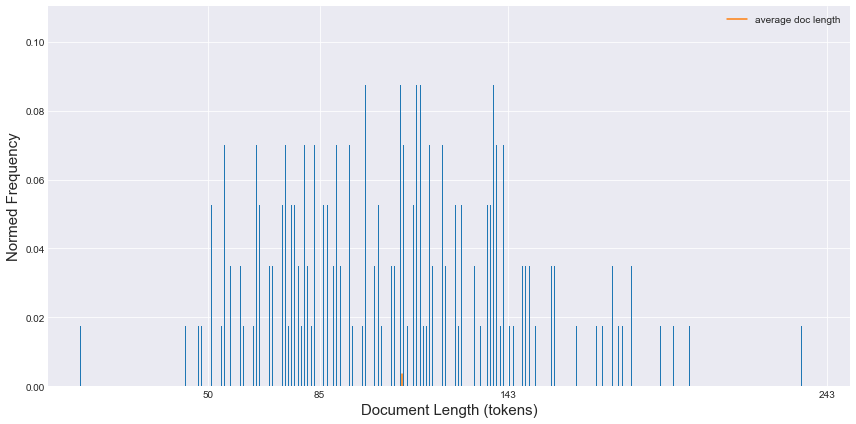

In [12]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,250)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

### Split the corpus into training and testing
Here we will split the corpus into training and testing sets.

The training set will be used to train the LDA model on, while the testing set will be used to retrieve similar articles later in our recommendation algorithm.

The dataframe is already shuffled from the begining, so no need to do it again.

In [68]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.996

In [69]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [70]:
print(len(df),len(train_df),len(test_df))

254 253 1


In [71]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 35
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [72]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  254 articles:  0.019857601324717204 min


/Users/juandrevanheerden/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
19     5.885210        1       1  0.094381  0.027215
9      5.548893        1       2  0.028135 -0.053667
33     5.398321        1       3  0.073590  0.033922
32     4.594227        1       4 -0.067442 -0.025967
30     4.478127        1       5  0.013897 -0.021391
17     4.466768        1       6  0.039172  0.009425
22     4.214054        1       7  0.163738  0.027715
6      4.104095        1       8 -0.000324 -0.047767
8      3.705086        1       9 -0.045281 -0.003185
2      3.366857        1      10 -0.079355  0.046621
5      3.176064        1      11 -0.019383  0.009018
11     3.151932        1      12 -0.031738  0.014033
24     3.133134        1      13 -0.022752  0.022166
27     3.104717        1      14  0.182467  0.032476
29     3.100819        1      15 -0.090599  0.037559
12     3.034201        1      16 -0.037470 -0.030325
13     2.979565        1      17  0.077020 -0.022120
18     2.974502        1      18 -0.077518 -0.073846
10     2.720902        1      19  0.017860 -0.015591
3      2.427125        1      20 -0.015870 -0.160686
7      2.323709        1      21  0.077348  0.000294
20     2.317894        1      22  0.063784 -0.057446
31     2.279032        1      23 -0.121759  0.159420
14     2.205841        1      24  0.019357  0.059645
25     1.919117        1      25 -0.063578 -0.096429
21     1.879584        1      26 -0.097375  0.080472
15     1.705375        1      27 -0.075394 -0.050344
16     1.623993        1      28 -0.002024 -0.172674
26     1.544137        1      29  0.028292  0.130305
0      1.507609        1      30  0.044691  0.085728
1      1.297808        1      31 -0.023549  0.076797
23     1.091256        1      32 -0.069449  0.006155
28     0.952034        1      33  0.083262 -0.014330
4      0.929731        1      34 -0.049245  0.001770
34     0.858277        1      35 -0.016888 -0.014967, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
18    Default  294.000000       forens  294.000000  30.0000  30.0000
10    Default  264.000000        digit  264.000000  29.0000  29.0000
502   Default   96.000000       social   96.000000  28.0000  28.0000
515   Default   68.000000  architectur   68.000000  27.0000  27.0000
9     Default  202.000000         data  202.000000  26.0000  26.0000
792   Default   58.000000         bank   58.000000  25.0000  25.0000
221   Default  136.000000       attack  136.000000  24.0000  24.0000
526   Default  185.000000     investig  185.000000  23.0000  23.0000
60    Default  125.000000        mobil  125.000000  22.0000  22.0000
309   Default  105.000000      privaci  105.000000  21.0000  21.0000
1504  Default  107.000000        cloud  107.000000  20.0000  20.0000
959   Default   67.000000        engin   67.000000  19.0000  19.0000
260   Default  210.000000      network  210.000000  18.0000  18.0000
77    Default  166.000000         user  166.000000  17.0000  17.0000
106   Default  255.000000       system  255.000000  16.0000  16.0000
173   Default  132.000000         risk  132.000000  15.0000  15.0000
2384  Default   59.000000      android   59.000000  14.0000  14.0000
22    Default  105.000000      organis  105.000000  13.0000  13.0000
158   Default  159.000000        manag  159.000000  12.0000  12.0000
89    Default   89.000000         evid   89.000000  11.0000  11.0000
146   Default   71.000000       govern   71.000000  10.0000  10.0000
668   Default  100.000000       detect  100.000000   9.0000   9.0000
203   Default   60.000000          ict   60.000000   8.0000   8.0000
923   Default   41.000000      biometr   41.000000   7.0000   7.0000
296   Default   45.000000        ident   45.000000   6.0000   6.0000
915   Default   25.000000          tag   25.000000   5.0000   5.0000
93    Default  137.000000    framework  137.000000   4.0000   4.

### Let's inspect some topics!

Bear in mind, when we see the words they may seem shortened. Recall this is because of our stemming function we previously implemented.

In [74]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
pprint(lda.show_topics(num_topics=35, num_words=20))

[(0,
  '0.040*"data" + 0.033*"file" + 0.024*"encrypt" + 0.021*"cloud" + '
  '0.016*"translat" + 0.015*"entropi" + 0.015*"user" + 0.015*"forens" + '
  '0.015*"volum" + 0.013*"storag" + 0.010*"electron" + 0.010*"provid" + '
  '0.010*"document" + 0.010*"authoris" + 0.010*"system" + 0.010*"searchabl" + '
  '0.010*"digit" + 0.008*"secur" + 0.008*"signific" + 0.008*"servic"'),
 (1,
  '0.032*"privaci" + 0.027*"malici" + 0.023*"data" + 0.020*"host" + '
  '0.020*"fingerprint" + 0.017*"cloud" + 0.014*"comput" + 0.013*"traffic" + '
  '0.013*"network" + 0.012*"analysi" + 0.011*"base" + 0.011*"honeypot" + '
  '0.010*"telescop" + 0.009*"aspect" + 0.009*"framework" + 0.009*"definit" + '
  '0.009*"multifacet" + 0.009*"preserv" + 0.009*"address" + 0.008*"manag"'),
 (2,
  '0.015*"system" + 0.014*"properti" + 0.012*"analysi" + 0.012*"model" + '
  '0.012*"attack" + 0.011*"face" + 0.010*"base" + 0.010*"smartphon" + '
  '0.010*"function" + 0.010*"risk" + 0.010*"hash" + 0.009*"applic" + '
  '0.008*"similar" 

#### We can inspect individual topics as such

Note that if you re run the model again, as it is non-deterministic, word contributions to topics and topic ID's will change.

In [75]:
lda.show_topic(topicid=4, topn=20)

[('denialofservic', 0.024099547),
 ('attack', 0.022585845),
 ('provid', 0.013203985),
 ('distribut', 0.012127564),
 ('comput', 0.0117515605),
 ('internet', 0.011664269),
 ('social', 0.01142991),
 ('system', 0.010950249),
 ('economi', 0.010589313),
 ('engin', 0.010213329),
 ('impact', 0.01011894),
 ('control', 0.0097802),
 ('manag', 0.009589498),
 ('relationship', 0.009028522),
 ('effect', 0.008958879),
 ('dematel', 0.008882948),
 ('improv', 0.008738081),
 ('detect', 0.00797291),
 ('model', 0.007661402),
 ('infrastructur', 0.007605036)]

In [76]:
lda.show_topic(topicid=15, topn=20)

[('user', 0.028783277),
 ('complianc', 0.017330524),
 ('univers', 0.0147063555),
 ('polici', 0.013878784),
 ('experi', 0.013140921),
 ('attack', 0.012722408),
 ('featur', 0.010892046),
 ('data', 0.010427706),
 ('behaviour', 0.010275612),
 ('person', 0.010044266),
 ('awar', 0.009886823),
 ('visual', 0.007912997),
 ('measur', 0.007851571),
 ('regul', 0.007690732),
 ('impact', 0.0075655472),
 ('cyber', 0.0074047553),
 ('threat', 0.0070048105),
 ('privaci', 0.006993806),
 ('framework', 0.006977909),
 ('factor', 0.0069569084)]

In [77]:
lda.show_topic(topicid=1, topn=20)

[('privaci', 0.032471433),
 ('malici', 0.0273378),
 ('data', 0.02298206),
 ('host', 0.020345405),
 ('fingerprint', 0.020044597),
 ('cloud', 0.017316736),
 ('comput', 0.01406116),
 ('traffic', 0.013430927),
 ('network', 0.013274009),
 ('analysi', 0.012177866),
 ('base', 0.011422148),
 ('honeypot', 0.010526441),
 ('telescop', 0.010263011),
 ('aspect', 0.009044458),
 ('framework', 0.008895391),
 ('definit', 0.00884306),
 ('multifacet', 0.00884306),
 ('preserv', 0.00884306),
 ('address', 0.0087137045),
 ('manag', 0.008495566)]

In [78]:
lda.show_topic(topicid=11, topn=20)

[('system', 0.029806975),
 ('social', 0.025424287),
 ('network', 0.017631907),
 ('threat', 0.017582646),
 ('user', 0.01625801),
 ('detect', 0.015632076),
 ('intrus', 0.0087023005),
 ('cyber', 0.008606316),
 ('effect', 0.008549579),
 ('human', 0.008291524),
 ('attack', 0.007628545),
 ('game', 0.0073980284),
 ('applic', 0.007199165),
 ('increas', 0.007008035),
 ('cloud', 0.006934082),
 ('base', 0.006763381),
 ('manag', 0.006703276),
 ('websit', 0.0065501425),
 ('design', 0.0064538205),
 ('engin', 0.00643202)]

In [79]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,2])
print(random_article_index)

7


In [80]:
pprint(train_df.iloc[random_article_index,2])

['understand',
 'cultur',
 'conceptu',
 'framework',
 'import',
 'establish',
 'cultur',
 'organ',
 'well',
 'establish',
 'idea',
 'aim',
 'cultur',
 'address',
 'variou',
 'human',
 'factor',
 'affect',
 'organ',
 'overal',
 'effort',
 'understand',
 'variou',
 'element',
 'cultur',
 'well',
 'relationship',
 'element',
 'still',
 'problemat',
 'schein',
 'corpor',
 'cultur',
 'aid',
 'understand',
 'cultur',
 'briefli',
 'introduc',
 'schein',
 'model',
 'incorpor',
 'import',
 'role',
 'knowledg',
 'final',
 'conceptu',
 'framework',
 'aid',
 'understand',
 'interact',
 'variou',
 'element',
 'cultur',
 'present',
 'framework',
 'explain',
 'mean',
 'illustr',
 'exampl',
 'suggest',
 'conceptu',
 'framework',
 'aid',
 'understand',
 'cultur',
 'understand',
 'cultur',
 'conceptu',
 'framework']


In [81]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])


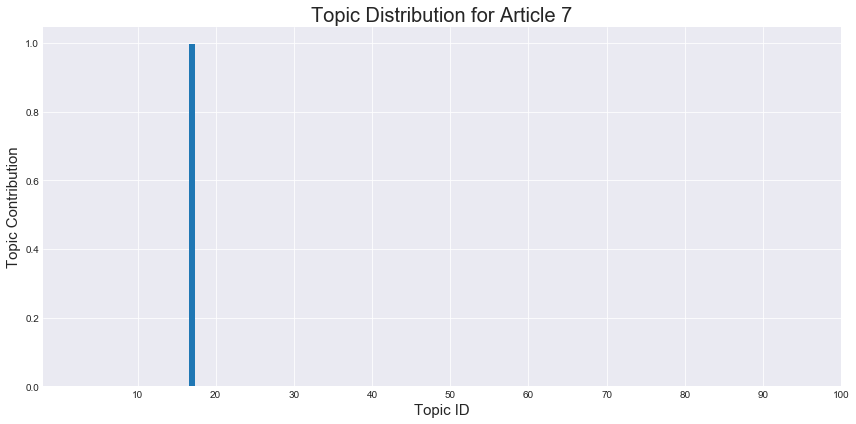

In [82]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

Ok, so clearly this document has various contributions from different topics. But what are these topics? Lets find out!

In [83]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

17 [('forens', 0.023813212), ('digit', 0.013030385), ('control', 0.012233086), ('technolog', 0.009494872), ('network', 0.0093217185), ('commun', 0.00918957), ('cultur', 0.0076971604), ('readi', 0.007508548), ('user', 0.0074155964), ('data', 0.0069189793)] 

8 [('system', 0.028852873), ('detect', 0.016899792), ('network', 0.01570477), ('measur', 0.015542934), ('manag', 0.014560055), ('risk', 0.011950544), ('attack', 0.010666513), ('metric', 0.009879947), ('complianc', 0.00951774), ('protect', 0.0092279045)] 

14 [('detect', 0.01627794), ('phish', 0.013649639), ('gener', 0.011611242), ('malwar', 0.010054346), ('analysi', 0.009796031), ('ioc', 0.00962933), ('trust', 0.009545647), ('data', 0.008790811), ('csirt', 0.008667246), ('framework', 0.008649772)] 

13 [('level', 0.01816054), ('polici', 0.017797368), ('imag', 0.016823087), ('privaci', 0.016483897), ('control', 0.014102507), ('monitor', 0.011135517), ('workplac', 0.009918693), ('govern', 0.009627307), ('measur', 0.009235444), ('addre

# Similarity Queries and Unseen Data

We will now turn our attention to the test set of data which the model has not yet seen. Although the articles in *test_df* have been unseen by the model, gensim has a way of infering their topic distributions given the trained model. Of course, the correct approach to yield accurate results would be to retrain the model with these new articles part of the corpus, but this can be timely and infeasable in a real case scenario where results are needed quickly.

First, lets show how we can infer document topics for a new unseen article.

In [84]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
#print(random_article_index)
print(test_df['title'])

0    A Framework of Opportunity-Reducing Techniques...
Name: title, dtype: object


Here's the important bit. In obtaining the BOW representation for this unseen article, gensim cleverly only considers words in the existing dictionary we used to train the model. So if there are new words in this article, they will not be considered when infering the topic distribution. This is good in that no errors arise for unseen words, but bad in that some words may be cut out, and therefore we could miss out on an accurate topic distribution for this article.

However, we mitigate this risk because the training set is very much representative of the entire corpus; 99.9% of the observations are in the training set, with only 0.01% of observations in the test set. So most, if not all, words from the test set should be in the training set's dictionary.

In [85]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,2])

In [86]:
print(test_df.iloc[random_article_index,2])

['framework', 'opportunityreduc', 'techniqu', 'mitig', 'insid', 'threattoward', 'best', 'practic', 'present', 'unifi', 'framework', 'deriv', 'extant', 'opportunityreduc', 'techniqu', 'employ', 'mitig', 'insid', 'threat', 'leverag', 'best', 'practic', 'although', 'requir', 'commit', 'malefic', 'focus', 'concept', 'tangibl', 'pragmat', 'reflect', 'opportunityreduc', 'measur', 'situat', 'crime', 'prevent', 'theori', 'evolv', 'criminolog', 'theori', 'respect', 'opportunityreduc', 'techniqu', 'theori', 'basi', 'theoret', 'framework', 'deriv', 'framework', 'highlight', 'sever', 'area', 'may', 'assist', 'organ', 'implement', 'control', 'situat', 'appropri', 'mitig', 'insid', 'threat', 'framework', 'opportunityreduc', 'techniqu', 'mitig', 'insid', 'threattoward', 'best', 'practic']


In [87]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])
new_doc_distribution

array([1.4630580e-04, 1.4630580e-04, 1.4630580e-04, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 1.4630580e-04, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 9.9502563e-01, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 1.4630580e-04, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 1.4630580e-04, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 1.4630580e-04, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 1.4630580e-04, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 1.4630580e-04, 1.4630580e-04,
       1.4630580e-04, 1.4630580e-04, 1.4630580e-04], dtype=float32)

Let's do the same visual analysis as before on this new unseen document

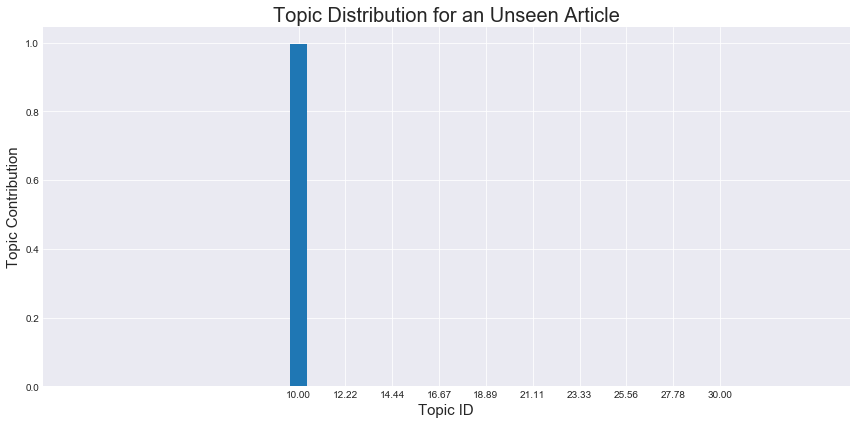

In [88]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,30,10))
fig.tight_layout()
plt.show()

In [89]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

10 [('privaci', 0.024872694), ('servic', 0.018477714), ('organis', 0.0119406525), ('framework', 0.009253904), ('manag', 0.009111821), ('requir', 0.008508414), ('popi', 0.008273205), ('mobil', 0.008223215), ('address', 0.008080678), ('data', 0.008066662)] 

34 [('techniqu', 0.022657918), ('network', 0.022431737), ('mobil', 0.01911533), ('ident', 0.019036267), ('devic', 0.017935935), ('trace', 0.01755182), ('investig', 0.01564292), ('data', 0.015282668), ('email', 0.013437851), ('secur', 0.013368687)] 

8 [('system', 0.028852873), ('detect', 0.016899792), ('network', 0.01570477), ('measur', 0.015542934), ('manag', 0.014560055), ('risk', 0.011950544), ('attack', 0.010666513), ('metric', 0.009879947), ('complianc', 0.00951774), ('protect', 0.0092279045)] 

14 [('detect', 0.01627794), ('phish', 0.013649639), ('gener', 0.011611242), ('malwar', 0.010054346), ('analysi', 0.009796031), ('ioc', 0.00962933), ('trust', 0.009545647), ('data', 0.008790811), ('csirt', 0.008667246), ('framework', 0.00

In [90]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(253, 35)

In [91]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))


Let's compare the new unseen document, to the corpus, and see which articles are most similar.

In [92]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [93]:
print(lda[corpus])

In [94]:
awe = jensen_shannon(new_doc_distribution,doc_topic_dist)
print(awe)

[8.2949764e-01 8.2961309e-01 8.2911932e-01 8.3064193e-01 8.2961315e-01
 8.3024633e-01 8.3027148e-01 8.2969677e-01 8.3085507e-01 8.3029747e-01
 6.7786354e-01 8.3016855e-01 8.2920504e-01 8.2941192e-01 8.2963586e-01
 8.3064187e-01 8.3028764e-01 8.2981479e-01 8.3041579e-01 8.3025700e-01
 8.3065969e-01 8.3076560e-01 8.2980978e-01 8.3018029e-01 8.3049506e-01
 7.7341592e-01 8.2958186e-01 8.3009541e-01 8.3005661e-01 8.3044857e-01
 8.3045673e-01 8.3064783e-01 8.2925034e-01 8.2999724e-01 8.2928962e-01
 8.2925034e-01 8.2981330e-01 8.2928610e-01 8.3020318e-01 8.3002895e-01
 8.2963467e-01 8.3027744e-01 8.3044857e-01 7.1943641e-01 8.3033597e-01
 8.3070427e-01 8.3027351e-01 8.3022505e-01 8.3032662e-01 8.3075583e-01
 8.2969928e-01 8.2995683e-01 8.3043236e-01 8.2973599e-01 8.3015680e-01
 8.3039010e-01 8.2986158e-01 8.2979184e-01 8.2957929e-01 8.3006942e-01
 8.2995689e-01 6.9557625e-01 8.2894200e-01 8.2994151e-01 8.3016855e-01
 8.3026731e-01 8.2979184e-01 8.2973605e-01 8.3020294e-01 8.3098263e-01
 8.255

In [95]:
#sort = []
#nul = "0"
#for x in jensen_shannon(new_doc_distribution,doc_topic_dist):
##    if x <= 0.7:
#        sort.append(x)
#    else: sort.append(nul)

#print(sort)
train_df.head(31)


,title,abstracts,tokenized
0,AUTHORISED TRANSLATIONS OF ELECTRONIC DOCUMENTS,AUTHORISED TRANSLATIONS OF ELECTRONIC DOCUMENT...,"[authoris, translat, electron, document, conce..."
1,TRUSTED COMPUTING IN MOBILE ACTION,TRUSTED COMPUTING IN MOBILE ACTION Due to the ...,"[trust, comput, mobil, action, due, converg, v..."
2,TOWARDS SECURITY EVALUATION BASED ON EVIDENCE ...,TOWARDS SECURITY EVALUATION BASED ON EVIDENCE ...,"[toward, evalu, base, evid, collect, evalu, so..."
3,THE PECULIUM MODEL: INFORMATION SECURITY RISK ...,THE PECULIUM MODEL: INFORMATION SECURITY RISK ...,"[peculium, model, risk, manag, south, african,..."
4,A FRAMEWORK FOR EVALUATING ICT SECURITY AWAREN...,A FRAMEWORK FOR EVALUATING ICT SECURITY AWAREN...,"[framework, evalu, ict, awar, ict, resourc, im..."
5,DENIAL-OF-SERVICE & DISTRIBUTED DENIAL-OF-SERV...,DENIAL-OF-SERVICE & DISTRIBUTED DENIAL-OF-SERV...,"[denialofservic, distribut, denialofservic, in..."
6,TICKET BASED IDENTITY SYSTEM FOR DRM,TICKET BASED IDENTITY SYSTEM FOR DRM One of th...,"[ticket, base, ident, system, drm, one, major,..."
7,UNDERSTANDING INFORMATION SECURITY CULTURE: A ...,UNDERSTANDING INFORMATION SECURITY CULTURE: A ...,"[understand, cultur, conceptu, framework, impo..."
8,A SOCIAL-TECHNICAL VIEW OF ICT SECURITY ISSUES...,A SOCIAL-TECHNICAL VIEW OF ICT SECURITY ISSUES...,"[socialtechn, view, ict, issu, trend, challeng..."
9,CASE STUDY OF THE USAGE OF AN AUTHENTICATION A...,CASE STUDY OF THE USAGE OF AN AUTHENTICATION A...,"[case, usag, authent, author, infrastructur, a..."


In [96]:
#print(liss)
#print(new_doc_distribution)
#print(doc_topic_dist)

In [97]:
liss = np.array(jensen_shannon(new_doc_distribution,doc_topic_dist))
print(liss[1])
sortlist = []
nul = 0
for x in liss:
    if x <= 0.7:
        sortlist.append(x)
    

sortlist.sort
pprint(sortlist)

0.8296131
[0.67786354,
 0.69557625,
 0.0007676095,
 0.43794405,
 0.24139032,
 0.004152029,
 0.00076744566,
 0.018686013,
 0.004584182,
 0.015950127]


In [98]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)
most_sim_ids

array([217,  80, 184, 223, 234, 219, 167, 132,  10,  61])

In [99]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df

,title,abstracts,tokenized
10,OUTSOURCING ICT SECURITY TO MSSP: ISSUES AND C...,OUTSOURCING ICT SECURITY TO MSSP: ISSUES AND C...,"[outsourc, ict, mssp, issu, challeng, develop,..."
61,DISCUSSING E-GOVERNMENT MATURITY MODELS FOR DE...,DISCUSSING E-GOVERNMENT MATURITY MODELS FOR DE...,"[discuss, egovern, matur, model, develop, worl..."
80,Secure Publish-Subscribe Mediated Virtual Orga...,Secure Publish-Subscribe Mediated Virtual Orga...,"[secur, publishsubscrib, mediat, virtual, orga..."
132,A conceptual model for digital forensic readiness,A conceptual model for digital forensic readin...,"[conceptu, model, digit, forens, readi, evergr..."
167,A Conceptual Opportunity-based Framework to Mi...,A Conceptual Opportunity-based Framework to Mi...,"[conceptu, opportunitybas, framework, mitig, i..."
184,Concerns Regarding Service Authorization by IP...,Concerns Regarding Service Authorization by IP...,"[concern, regard, servic, author, ip, address,..."
217,Intrusion Detection in Bluetooth Enabled Mobil...,Intrusion Detection in Bluetooth Enabled Mobil...,"[intrus, detect, bluetooth, enabl, mobil, phon..."
219,Mapping ‘Security Safeguard’ Requirements in a...,Mapping ‘Security Safeguard’ Requirements in a...,"[map, safeguard, requir, data, privaci, legisl..."
223,Risk-Driven Security Metrics Development for a...,Risk-Driven Security Metrics Development for a...,"[riskdriven, metric, develop, ehealth, iot, ap..."
234,Unsolicited Short Message Service Marketing- A...,Unsolicited Short Message Service Marketing- A...,"[unsolicit, short, messag, servic, market, pre..."


In [100]:
test_df.head()
#most_similar_df

,title,abstracts,tokenized
0,A Framework of Opportunity-Reducing Techniques...,A Framework of Opportunity-Reducing Techniques...,"[framework, opportunityreduc, techniqu, mitig,..."


In [101]:
columns_new = ['score']
awe = awe.astype(object)
lekker = pd.DataFrame(awe, columns=columns_new)
boom = pd.concat([train_df, lekker], axis=1)
boom

,title,abstracts,tokenized,score
0,AUTHORISED TRANSLATIONS OF ELECTRONIC DOCUMENTS,AUTHORISED TRANSLATIONS OF ELECTRONIC DOCUMENT...,"[authoris, translat, electron, document, conce...",0.829498
1,TRUSTED COMPUTING IN MOBILE ACTION,TRUSTED COMPUTING IN MOBILE ACTION Due to the ...,"[trust, comput, mobil, action, due, converg, v...",0.829613
2,TOWARDS SECURITY EVALUATION BASED ON EVIDENCE ...,TOWARDS SECURITY EVALUATION BASED ON EVIDENCE ...,"[toward, evalu, base, evid, collect, evalu, so...",0.829119
3,THE PECULIUM MODEL: INFORMATION SECURITY RISK ...,THE PECULIUM MODEL: INFORMATION SECURITY RISK ...,"[peculium, model, risk, manag, south, african,...",0.830642
4,A FRAMEWORK FOR EVALUATING ICT SECURITY AWAREN...,A FRAMEWORK FOR EVALUATING ICT SECURITY AWAREN...,"[framework, evalu, ict, awar, ict, resourc, im...",0.829613
5,DENIAL-OF-SERVICE & DISTRIBUTED DENIAL-OF-SERV...,DENIAL-OF-SERVICE & DISTRIBUTED DENIAL-OF-SERV...,"[denialofservic, distribut, denialofservic, in...",0.830246
6,TICKET BASED IDENTITY SYSTEM FOR DRM,TICKET BASED IDENTITY SYSTEM FOR DRM One of th...,"[ticket, base, ident, system, drm, one, major,...",0.830271
7,UNDERSTANDING INFORMATION SECURITY CULTURE: A ...,UNDERSTANDING INFORMATION SECURITY CULTURE: A ...,"[understand, cultur, conceptu, framework, impo...",0.829697
8,A SOCIAL-TECHNICAL VIEW OF ICT SECURITY ISSUES...,A SOCIAL-TECHNICAL VIEW OF ICT SECURITY ISSUES...,"[socialtechn, view, ict, issu, trend, challeng...",0.830855
9,CASE STUDY OF THE USAGE OF AN AUTHENTICATION A...,CASE STUDY OF THE USAGE OF AN AUTHENTICATION A...,"[case, usag, authent, author, infrastructur, a...",0.830297


In [351]:
#yellow = []
#for i in awe:
#    yellow[i] = awe[i+1] - awe[i]
    

#print(yellow)
#v = []

#ja = np.diff(awe)
#for i in awe:
#        pprint(i)
#awe2 = awe.sort(axis=-1)
#print(awe2)
#print(len(i))
#awe.sort(order=None)
#ja = np.diff(awe)
#pprint(ja)
difflist = []
num = 0
for idx, val in enumerate(awe):
    
    diff = awe[idx+1,val] - awe[idx,val]
    difflist.append(diff)
    #print(idx, val)
    
print(difflist)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [46]:
#df.to_csv("test1.csv", sep='\t')

In [103]:
v = [awe[i+1]-awe[i] for i in range(len(awe)-1)]

print(v)

[0.00011545419692993164, -0.0004937648773193359, 0.0015226006507873535, -0.0010287761688232422, 0.0006331801414489746, 2.5153160095214844e-05, -0.0005747079849243164, 0.001158297061920166, -0.0005576014518737793, -0.15243393182754517, 0.152305006980896, -0.0009635090827941895, 0.00020688772201538086, 0.00022393465042114258, 0.001006007194519043, -0.0003542304039001465, -0.00047284364700317383, 0.0006009936332702637, -0.00015878677368164062, 0.00040268898010253906, 0.00010591745376586914, -0.0009558200836181641, 0.0003705024719238281, 0.0003147721290588379, -0.05707913637161255, 0.05616593360900879, 0.0005135536193847656, -3.88026237487793e-05, 0.00039196014404296875, 8.165836334228516e-06, 0.00019109249114990234, -0.0013974905014038086, 0.0007469058036804199, -0.0007076263427734375, -3.927946090698242e-05, 0.0005629658699035645, -0.0005272030830383301, 0.0009170770645141602, -0.0001742243766784668, -0.000394284725189209, 0.0006427764892578125, 0.00017112493515014648, -0.111012160778045